# Условия

Значения всех параметров (матрицы вероятностей, размерности и т.п.) должны определяться один раз, после чего для вычислений уже используются переменные. "Хардкодить"числа внутри кода не допускается.
- Для заданных матриц переходных вероятностей $M$ и эмиссионных вероятностей $E$ сгенерировать последовательность $\sigma$ скрытых состояний и последовательность $\varepsilon$ наблюдений длины $L$. В качестве начального распределения использовать стационарное распределение матрицы $M$ (собственный вектор, соответсвтующий единичному собственному значению).
- Реализовать алгоритм Витерби: для данных $M, E$ и $\varepsilon$ найти

$$
\sigma_v=\operatorname{argmax}_{\sigma^{\prime}} P\left(\sigma^{\prime}, \varepsilon \mid M, E\right)
$$


Визуализировать результат: построить на графике $\sigma$ и $\sigma_v$ (на оси $x$ позиция, на оси $y$ - номер состояния).
- Реализовать алгоритмы прямого и обратного хода (особое внимание уделите инициализации алгоритмов!). Вычислить $P(\varepsilon)$ с помощью обоих алгоритмов.
- Реализовать апостериорное декодирование.

Визуализировать результат: построить график $P($ state $0 \mid \varepsilon)(l)$.
- Реализовать алгоритм Баума-Велша.

Протестировать алгоритмы для $L=100,500,1000$. Добавить защиту от потери точности через logsumexp и/или нормализацию (см. учебник Durbin et al).

## Разбалловка

* Генератор (первый пункт) и алгоритм Витерби без защиты от потери точности: 4 балла.

* Прямой и обратный ход + апостериорное декодирование (без защиты от потери точности): +3 балла (итого 7).

* Защита от потери точности Витерби: +1 балл

* Защита от потери точности прямого, обратного алгоритмов и апостериорного декодирования: +1 балл

* Алгоритм Баума-Велша - на десятку.

При защите работы могу спрашивать любые дополнительные вопросы по выполненной работе, включая определения вероятностного пространства, независимости событий, условной вероятности, а также просить пояснить, что делают куски кода, используемые функции и методы из numpy и т.п.

Отдельно обращая ваше внимание на условие использовать стационарное распределение (тоже нужно знать, что это) в качестве начального.

Защиту от потери точности проще выполнять через вычисления в log. Тогда суммирование выполняется при помощи функции logsumexp (на Википедии нормально описано, можно пользоваться) - общий приём, который может быть полезен в других задачах. Можно делать через нормализацию столбца на каждом шаге алгоритма (описано в книге), это существенно быстрее, но по опыту проще запутаться и больше времени требуется на отладку.

# Код

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

In [3]:
# ====================================================
# Define parameters for the Casino HMM problem
# ====================================================
# Two hidden states: 0 for Fair, 1 for Loaded.
# Six observations corresponding to dice outcomes 1-6.
n_states = 2
n_observations = 6

# Transition matrix M:
# Typical values for the casino problem:
#   Fair-to-Fair: 0.95, Fair-to-Loaded: 0.05
#   Loaded-to-Fair: 0.10, Loaded-to-Loaded: 0.90
M = np.array([[0.95, 0.05],
              [0.10, 0.90]])

# Emission matrix E:
#   For a fair die, outcomes are uniformly distributed (1/6 each).
#   For a loaded die, the probability of rolling a 6 is higher.
E = np.array([[1/6]*6,
              [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]])

In [4]:
# Compute the stationary distribution of M
def stationary_distribution(M):
    eigvals, eigvecs = np.linalg.eig(M.T)
    idx = np.argmin(np.abs(eigvals - 1))
    stat = np.real(eigvecs[:, idx])
    stat = stat / stat.sum()
    # Ensure nonnegative probabilities
    stat = np.abs(stat)
    stat = stat / stat.sum()
    return stat

pi = stationary_distribution(M)

In [6]:
# Viterbi algorithm in log-space
def viterbi(observations, M, E, pi):
    L = len(observations)
    log_dp = np.full((L, n_states), -np.inf)
    backpointer = np.zeros((L, n_states), dtype=int)
    log_pi = np.log(pi)
    log_E = np.log(E)
    log_M = np.log(M)

    # Initialization
    log_dp[0] = log_pi + log_E[:, observations[0]]

    # Recursion
    for t in range(1, L):
        for j in range(n_states):
            candidate = log_dp[t-1] + log_M[:, j]
            backpointer[t, j] = np.argmax(candidate)
            log_dp[t, j] = candidate[backpointer[t, j]] + log_E[j, observations[t]]

    # Backtracking
    sigma_v = np.empty(L, dtype=int)
    sigma_v[-1] = np.argmax(log_dp[-1])
    for t in range(L-2, -1, -1):
        sigma_v[t] = backpointer[t+1, sigma_v[t+1]]
    return sigma_v

In [7]:
# Forward algorithm with scaling
def forward(observations, M, E, pi):
    L = len(observations)
    alpha = np.zeros((L, n_states))
    scale = np.zeros(L)

    # Initialization
    alpha[0] = pi * E[:, observations[0]]
    scale[0] = alpha[0].sum()
    alpha[0] /= scale[0]

    # Recursion
    for t in range(1, L):
        alpha[t] = (alpha[t-1] @ M) * E[:, observations[t]]
        scale[t] = alpha[t].sum()
        alpha[t] /= scale[t]

    log_prob = np.sum(np.log(scale))
    return alpha, log_prob, scale

In [8]:
# Backward algorithm with scaling
def backward(observations, M, E, scale):
    L = len(observations)
    beta = np.zeros((L, n_states))
    beta[-1] = 1/scale[-1]
    for t in range(L-2, -1, -1):
        beta[t] = (M * E[:, observations[t+1]]).dot(beta[t+1])
        beta[t] /= scale[t]
    return beta

In [9]:
# Posterior decoding: compute gamma = P(state | observations)
def posterior_decoding(alpha, beta):
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

In [10]:
# Baum-Welch algorithm for parameter re-estimation
def baum_welch(observations, n_iter=100):
    L = len(observations)
    # Random initialization of parameters (only defined once at the start)
    A = np.random.dirichlet(np.ones(n_states), size=n_states)
    B = np.random.dirichlet(np.ones(n_observations), size=n_states)
    pi_est = np.random.dirichlet(np.ones(n_states))

    for iteration in range(n_iter):
        # E-step: Forward pass with scaling
        alpha = np.zeros((L, n_states))
        scale = np.zeros(L)
        alpha[0] = pi_est * B[:, observations[0]]
        scale[0] = alpha[0].sum()
        alpha[0] /= scale[0]
        for t in range(1, L):
            alpha[t] = (alpha[t-1] @ A) * B[:, observations[t]]
            scale[t] = alpha[t].sum()
            alpha[t] /= scale[t]

        # E-step: Backward pass with scaling
        beta = np.zeros((L, n_states))
        beta[-1] = 1/scale[-1]
        for t in range(L-2, -1, -1):
            beta[t] = (A * B[:, observations[t+1]]).dot(beta[t+1])
            beta[t] /= scale[t]

        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        # Compute xi: probability of being in state i at time t and j at t+1
        xi = np.zeros((L-1, n_states, n_states))
        for t in range(L-1):
            numerator = alpha[t][:, None] * A * B[:, observations[t+1]][None, :] * beta[t+1][None, :]
            denominator = numerator.sum()
            xi[t] = numerator / denominator

        # M-step: re-estimate parameters
        pi_est = gamma[0]
        A = xi.sum(axis=0)
        A /= A.sum(axis=1, keepdims=True)
        for i in range(n_states):
            for k in range(n_observations):
                B[i, k] = gamma[observations==k, i].sum()
            B[i] /= B[i].sum()

    return A, B, pi_est

In [13]:
# ====================================================
# Load and parse the casino.txt file :contentReference[oaicite:1]{index=1}
# ====================================================
with open("casino.txt", "r") as f:
    content = f.read().strip()
parts = content.split()
observations_str = parts[0]   # The first block: dice rolls (digits)
states_str = parts[1]         # The second block: true states ("F" or "L")

In [16]:
# Convert observations: map '1'-'6' to indices 0-5.
observations = np.array([int(ch)-1 for ch in observations_str if ch.isdigit()])
print(observations)

[2 0 4 0 0 5 1 3 5 3 3 5 5 3 3 1 3 4 2 0 0 2 1 0 5 2 0 0 5 3 0 4 1 0 2 2 5
 1 4 0 3 3 4 3 2 5 2 0 5 4 5 5 1 5 4 5 5 5 5 5 5 4 0 0 5 5 3 4 2 0 2 1 5 4
 0 1 3 4 5 2 5 5 5 3 5 2 0 5 2 5 5 5 2 0 5 1 2 1 5 3 4 4 1 2 5 1 5 5 5 5 5
 5 1 4 0 4 0 5 2 0 1 1 1 4 4 4 3 3 0 5 5 5 4 5 5 4 5 2 4 5 3 2 1 3 2 5 3 0
 2 0 4 0 2 3 5 4 0 3 5 2 4 2 3 0 0 0 1 5 3 0 3 5 1 5 1 4 2 2 4 5 2 5 5 0 5
 2 5 5 5 3 5 5 1 2 1 4 2 3 3 0 2 5 5 0 5 5 0 0 5 2 1 4 1 4 5 1 3 5 1 1 4 4
 1 5 4 1 4 1 1 5 5 3 2 4 2 4 2 2 2 5 1 2 2 0 1 0 5 1 4 2 5 3 3 0 3 3 2 1 2
 2 4 0 5 2 1 3 2 5 2 2 5 5 4 4 5 1 3 5 5 5 5 1 5 2 1 5 5 5 5 0 1 2 4 4 1 3
 4 1 3 1]


In [17]:
# Convert true states: 'F' becomes 0 (fair) and 'L' becomes 1 (loaded).
true_states = np.array([0 if ch=='F' else 1 for ch in states_str if ch in ['F','L']])
print(true_states)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0]


In [18]:
# Check that both sequences have equal length.
assert len(observations) == len(true_states), "Mismatch between observation and state sequence lengths."
L = len(observations)
print(f"Loaded casino data with sequence length L = {L}")

Loaded casino data with sequence length L = 300


In [ ]:
# ====================================================
# Run HMM Algorithms on the Casino Data
# ====================================================

In [19]:
# 1. Viterbi decoding to infer the most likely state sequence.
sigma_v = viterbi(observations, M, E, pi)

In [20]:
# 2. Forward and Backward algorithms to compute log likelihood.
alpha, log_prob_forward, scale = forward(observations, M, E, pi)
beta = backward(observations, M, E, scale)
print(f"Log P(observations) (forward) = {log_prob_forward:.4f}")

Log P(observations) (forward) = -516.7397


In [22]:
# 3. Posterior decoding: compute gamma and extract P(Fair | observations)
gamma = posterior_decoding(alpha, beta)
p_fair = gamma[:, 0]

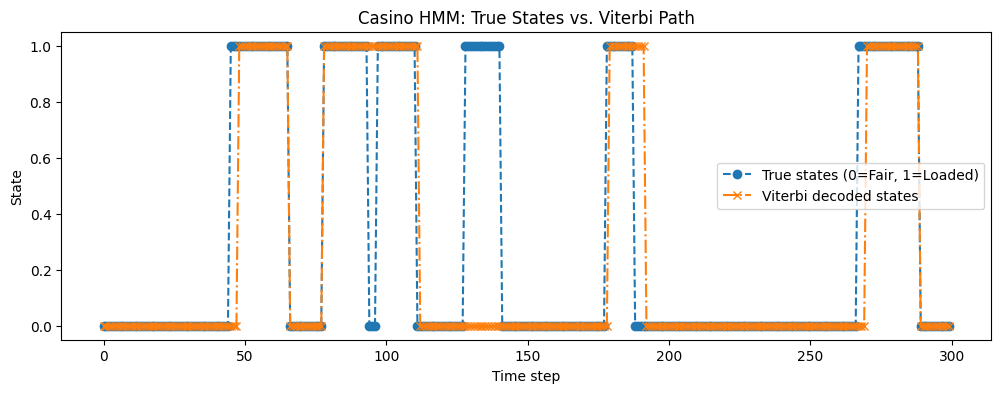

In [23]:
# ====================================================
# Visualization: True States vs. Viterbi Decoding
# ====================================================
plt.figure(figsize=(12,4))
plt.plot(true_states, label="True states (0=Fair, 1=Loaded)", marker="o", linestyle="--")
plt.plot(sigma_v, label="Viterbi decoded states", marker="x", linestyle="-.")
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Casino HMM: True States vs. Viterbi Path")
plt.legend()
plt.show()

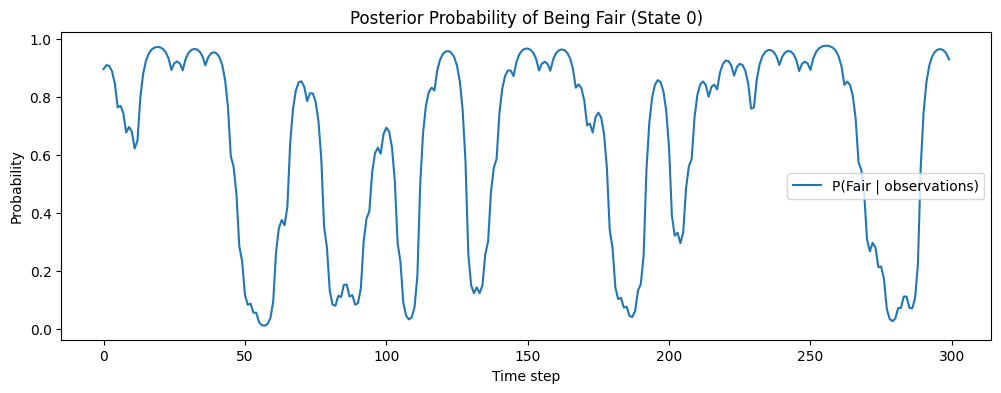

In [24]:
# ====================================================
# Visualization: Posterior Probability of Fair State
# ====================================================
plt.figure(figsize=(12,4))
plt.plot(p_fair, label="P(Fair | observations)")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("Posterior Probability of Being Fair (State 0)")
plt.legend()
plt.show()

In [25]:
# ====================================================
# 4. Baum-Welch Algorithm: Parameter Re-estimation
# ====================================================
A_est, B_est, pi_est = baum_welch(observations, n_iter=50)
print("Estimated Transition Matrix A:")
print(A_est)
print("\nEstimated Emission Matrix B:")
print(B_est)

Estimated Transition Matrix A:
[[0.61860533 0.38139467]
 [0.29788908 0.70211092]]

Estimated Emission Matrix B:
[[0.19836864 0.19437051 0.12477691 0.19785279 0.26507679 0.01955436]
 [0.0830611  0.10388164 0.19313741 0.06572986 0.04331576 0.51087423]]
